In [9]:
from typing import Any

from src.model_db.tiny_model_db import TinyModelDB

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from src.reinforcement_learning.algorithms.policy_mitosis.mitosis_policy_info import MitosisPolicyInfo
from src.model_db.model_db import ModelEntry
from src.trees import Forest


In [10]:
with TinyModelDB(base_path=f'E:/saved_models/rl/MultiAgentCartPole/6/mitosis-2024-05-28_20.00.00', readonly=True) as policy_db:
    policy_entries_sorted: list[ModelEntry[MitosisPolicyInfo]] = list(sorted(policy_db.all_entries(), key=lambda p: p['model_info']['score'], reverse=True))

In [11]:


policy_info_forest = Forest(
    [pe["model_info"] for pe in policy_entries_sorted], 
    get_id=lambda pi: pi['policy_id'], 
    get_parent_id=lambda pi: pi['parent_policy_id']
)

for policy_entry in policy_entries_sorted:
    print(f"id = {policy_entry['model_id']}, "
          f"score = {policy_entry['model_info']['score']:6.4f}, "
          f"parent_id = {str(policy_entry['parent_model_id'])}, "
          f"disc_num_desc = {policy_info_forest.compute_num_descendants(policy_entry['model_id'], discount_factor=0.5)}"
    )

id = 2024-06-02_02.51.29~AbI24Z, score = 22.3369, parent_id = 2024-06-02_01.55.11~ezssDB, disc_num_desc = 1.0
id = 2024-06-02_01.56.02~Kf97Yk, score = 18.1945, parent_id = 2024-06-01_21.11.21~26fcyT, disc_num_desc = 5.0
id = 2024-06-02_01.55.11~ezssDB, score = 15.5378, parent_id = 2024-06-02_01.18.19~AVovi0, disc_num_desc = 1.5
id = 2024-06-02_02.14.22~kIHWAu, score = 14.2325, parent_id = 2024-06-02_01.56.02~Kf97Yk, disc_num_desc = 1.0
id = 2024-06-02_01.55.45~knfnhr, score = 13.3010, parent_id = 2024-06-02_01.37.41~WbOww7, disc_num_desc = 0.0
id = 2024-06-02_02.13.35~VExnND, score = 12.7830, parent_id = 2024-06-01_22.05.43~T8uh1W, disc_num_desc = 0.0
id = 2024-06-02_03.29.07~Oz0oTT, score = 12.6320, parent_id = 2024-06-02_02.51.29~AbI24Z, disc_num_desc = 0.0
id = 2024-06-02_03.29.07~Qaw3Pc, score = 12.3549, parent_id = 2024-06-02_03.09.05~2Pd91V, disc_num_desc = 0.0
id = 2024-06-02_03.09.05~2Pd91V, score = 12.2518, parent_id = 2024-06-02_01.18.42~3TZ4pt, disc_num_desc = 1.0
id = 2024-

In [12]:
from src.np_functions import softmax
steps_trained = np.array([policy_entry['model_info']['steps_trained'] for policy_entry in policy_entries_sorted])
steps_trained = steps_trained / steps_trained.mean()
softmax(-steps_trained, temperature=1.0)

array([0.01027812, 0.01627438, 0.01152952, 0.01450797, 0.01293329,
       0.01450797, 0.00916254, 0.01536581, 0.01723666, 0.01450797,
       0.01627438, 0.01450797, 0.01450797, 0.01627438, 0.01450797,
       0.02047857, 0.01293329, 0.01627438, 0.01627438, 0.01825585,
       0.01293329, 0.01152952, 0.01293329, 0.01825585, 0.01450797,
       0.01293329, 0.0193353 , 0.01825585, 0.01450797, 0.0193353 ,
       0.02047857, 0.01825585, 0.01627438, 0.01825585, 0.01627438,
       0.02047857, 0.01825585, 0.0193353 , 0.02168945, 0.02297192,
       0.02168945, 0.02433023, 0.02168945, 0.02297192, 0.02433023,
       0.02433023, 0.02576885, 0.02729253, 0.02729253, 0.02433023,
       0.02576885, 0.03061551, 0.02890631, 0.02729253])

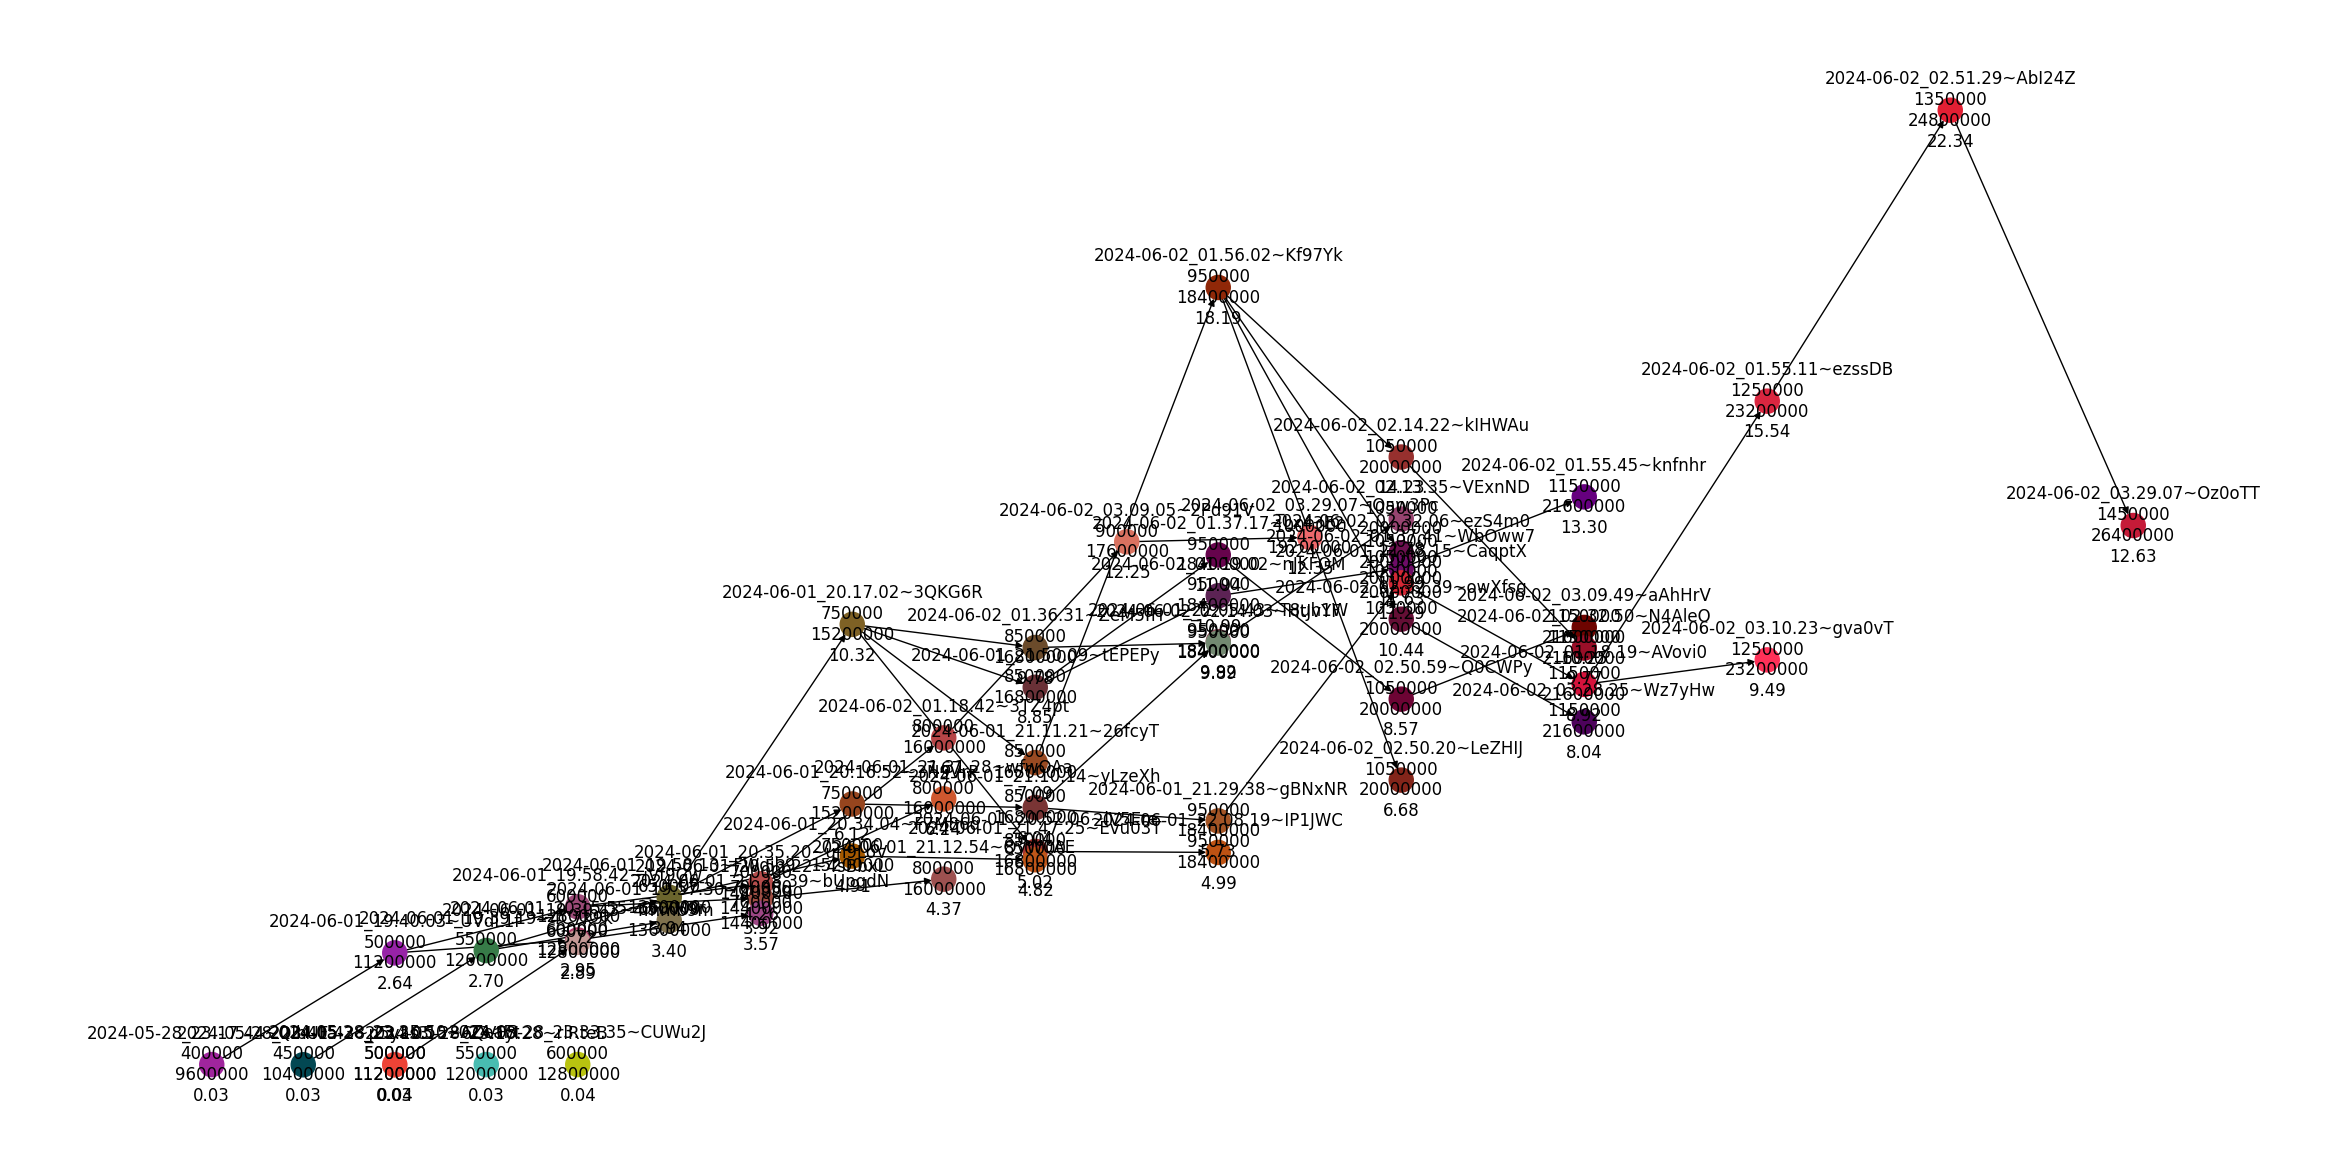

In [13]:
G = nx.DiGraph()

G.add_nodes_from(
    (policy_entry['model_id'], {
        'score': policy_entry['model_info']['score'], 
        'steps_trained': policy_entry['model_info']['steps_trained'],
        'env_steps_trained': policy_entry['model_info'].get('env_steps_trained', None)
    })
     for policy_entry 
     in policy_entries_sorted
     )

pos: dict[str, tuple[int, float]] = {}
for policy_entry in policy_entries_sorted:
    model_id = policy_entry['model_id']
    parent_id = policy_entry['parent_model_id']
    if parent_id is not None:
        G.add_edge(parent_id, model_id)
    
    model_info = policy_entry['model_info']
    pos[model_id] = (model_info['steps_trained'], model_info['score'])


def set_color_recursively(node_id: str, c: Any):
    colors[node_id] = c
    for neighbor_id in G.neighbors(node_id):
        c = np.clip(c + np.random.normal(loc=0, scale=0.1, size=3), 0, 1)
        set_color_recursively(neighbor_id, c)
    

colors: dict[str, np.ndarray] = {}
for root_id in (node for node, in_degree in G.in_degree() if in_degree == 0):
    color = list(np.random.random(3))
    set_color_recursively(root_id, color)

node_color = [colors[node_id] for node_id in G]

scores = nx.get_node_attributes(G, 'score')
steps_trained = nx.get_node_attributes(G, 'steps_trained')
env_steps_trained = nx.get_node_attributes(G, 'env_steps_trained')
labels: dict[str, str] = {}
for node_id, score in scores.items():
    labels[node_id] = f'{node_id}\n{steps_trained[node_id]}\n{env_steps_trained[node_id]}\n{score:.2f}'

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
nx.draw(G, pos, with_labels=True, labels=labels, node_color=node_color, ax=ax)


In [24]:
model_id = '2024-04-30_22.08.06'

def print_dict(d: dict):
    for key, value in d.items():
        if isinstance(value, dict):
            print(f"↓↓↓  {key:^15}  ↓↓↓")
            print_dict(value)
            print(f"↑↑↑  {key:^15}  ↑↑↑\n\n")
        else:
            print(f"======  {key:^15}  ======\n{value}\n")

print_dict(policy_db.fetch_entry(model_id))

ValueError: I/O operation on closed file.

In [3]:
policy_db.delete_entry('2024-04-30_09.24.10', delete_state_dict=True)

In [29]:
from src.np_functions import softmax
from typing import Iterable


def select_policy_selection_probs(policy_infos: Iterable[MitosisPolicyInfo]) -> np.ndarray:
    scores = np.array([policy_info['score'] for policy_info in policy_infos])
    scores = scores / scores.mean()
    scores = softmax(scores, temperature=0.9 / len(scores)**0.75)
    return scores

for a, b in zip([pe['model_info']['score'] for pe in policy_entries_sorted], select_policy_selection_probs([pe['model_info'] for pe in policy_entries_sorted])):
    print(f'{a:10.6f} | {b:10.6f}')

105.147080 |   0.137687
104.048683 |   0.099191
103.584046 |   0.086343
102.878299 |   0.069939
102.038949 |   0.054436
101.963269 |   0.053220
101.188135 |   0.042225
101.044739 |   0.040455
100.618744 |   0.035624
100.565270 |   0.035059
100.007646 |   0.029683
 99.735331 |   0.027365
 99.271013 |   0.023823
 99.250450 |   0.023677
 99.214204 |   0.023422
 98.322112 |   0.017945
 98.202376 |   0.017315
 97.892620 |   0.015786
 97.719628 |   0.014991
 97.713329 |   0.014963
 97.676681 |   0.014800
 97.120153 |   0.012534
 96.418970 |   0.010167
 96.406279 |   0.010128
 96.193215 |   0.009504
 96.141827 |   0.009359
 96.025261 |   0.009039
 96.022344 |   0.009031
 95.548201 |   0.007839
 95.318829 |   0.007320
 94.878648 |   0.006419
 94.348620 |   0.005479
 94.338467 |   0.005463
 93.676783 |   0.004484
 93.478932 |   0.004226
 92.801878 |   0.003453
 90.692926 |   0.001840
 89.479125 |   0.001280
 88.511817 |   0.000959
 88.076631 |   0.000842
 88.066244 |   0.000840
 84.983942 |   0

In [46]:

from tinydb import Query

# with TinyModelDB[MitosisPolicyInfo](base_path=f'E:/saved_models/rl/MultiAgentCartPole/6/mitosis-2024-05-28_20.00.00') as policy_db:
#     with TinyModelDB[MitosisPolicyInfo](base_path=f'E:/saved_models/rl/MultiAgentCartPole/6/mitosis-2024-05-28_20.00.00.backup_2024-06-01') as other_policy_db:
#         policy_db.copy_from(other_policy_db, entry_filter=lambda entry: entry['model_info']['score'] < 0.1)

In [3]:
from tinydb import Query

# with TinyModelDB[MitosisPolicyInfo](base_path=f'E:/saved_models/rl/MultiAgentCartPole/6/mitosis-2024-05-28_20.00.00') as policy_db:
#     policy_db.delete_entries(entry_filter=lambda entry: entry['model_info']['steps_trained'] < 300_000, delete_state_dict=True)